# Constants

In [1]:
TARGET = 'readmission_30d'
N_FOLDS = 5
MAX_EVALS = 30
TEST_SIZE = 0.3

# Import

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

import os
import yaml

import lightgbm as lgb

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score

import shap

from tqdm.notebook import tqdm

# Load

In [3]:
df_raw = pd.read_csv("dataset/processed_data.csv",
                     dtype={'date_procedure_9': 'str', 'date_procedure_10': 'str'})
df_raw.head()

,sex,dob,age,race,education_level,zipcode,patient_city,patient_state,underlying_heart_disease,heart_disease,...,n_procedure_180d,n_procedure_1year,classe_meds_cardio_qtde,meds_cardiovasc_qtde,meds_antimicrobianos,nyha_basal_group,cied_final_group_1,procedure_type_new,hospital_stay,split
0,1,1966-01-23,44.6,1.0,2.0,3343010,SAO PAULO,35.0,1.0,0.0,...,0,0,3.0,6.0,3.0,1.0,1,2,1,train
1,1,1961-09-29,51.1,1.0,4.0,71505275,BRASILIA,53.0,1.0,0.0,...,0,0,NaN,0.0,4.0,1.0,1,1,2,train
2,0,1945-08-09,60.1,1.0,4.0,71015068,BRASILIA,53.0,1.0,0.0,...,0,0,NaN,0.0,0.0,1.0,1,2,1,train
3,1,1948-01-25,61.0,1.0,4.0,70753010,BRASILIA,53.0,2.0,0.0,...,0,0,NaN,0.0,8.0,1.0,1,1,2,train
4,1,1934-10-06,69.1,1.0,999.0,70386110,BRASILIA,53.0,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,1,1,8,train


In [4]:
with open("auxiliar/significant_columns/categorical_{}.yaml".format(TARGET), "r") as stream:
    try:
        initial_cat_features = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

with open("auxiliar/significant_columns/numerical_{}.yaml".format(TARGET), "r") as stream:
    try:
        initial_num_features = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

initial_features = initial_cat_features + initial_num_features

In [5]:
exception_columns = ['death_intraop', 'death_intraop_1', 'disch_outcomes_t0']

correlated_columns = ['year_procedure_1',  # com year_adm_t0
                      'age_surgery_1',  # com age
                      'admission_t0',  # com admission_pre_t0_count
                      'atb',  # com meds_antimicrobianos
                      'classe_meds_cardio_qtde',  # com classe_meds_qtde
                      'suporte_hemod',  # com proced_invasivos_qtde,
                      'radiografia',  # com exames_imagem_qtde
                      'ecg'  # com metodos_graficos_qtde
                      ]

initial_features = list(set(initial_features) -
                        set(exception_columns + correlated_columns))

In [6]:
for cat_feature in initial_cat_features:
    df_raw[cat_feature] = df_raw[cat_feature].astype('category')

# Split

In [7]:
X_df = df_raw[initial_features]
y_df = df_raw[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df,
                                                    test_size=TEST_SIZE,
                                                    random_state=0,
                                                    stratify=y_df)

In [8]:
print("Training features shape: ", X_train.shape)
print("Testing features shape: ", X_test.shape)

Training features shape:  (11036, 76)
Testing features shape:  (4730, 76)


# Functions

In [9]:
def fit_lightgbm(features, hyperparameters=None, early_stopping=True, plot_importance=False, print_results=True):
    X_train_filtered = X_train[features]
    X_test_filtered = X_test[features]
    cat_features = list(set(features) & set(initial_cat_features))

    train_set = lgb.Dataset(data=X_train_filtered, label=y_train, free_raw_data=False,
                            categorical_feature=cat_features)

    test_set = lgb.Dataset(data=X_test_filtered, label=y_test, free_raw_data=False,
                           categorical_feature=cat_features)

    # Get default hyperparameters
    model = lgb.LGBMClassifier()

    if hyperparameters is None:
        hyperparameters = model.get_params()
        del hyperparameters['n_estimators']
        del hyperparameters['importance_type']
        del hyperparameters['silent']

    if early_stopping:
        callbacks = [lgb.early_stopping(stopping_rounds=200)]
        if 'n_estimators' in hyperparameters.keys():
            del hyperparameters['n_estimators']
    else:
        callbacks = None
    # Cross validation with early stopping
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round=10000,
                        callbacks=callbacks,
                        metrics='auc', nfold=N_FOLDS, seed=314,
                        categorical_feature=cat_features)

    # Optimal number of esimators found in cv
    model.n_estimators = len(cv_results['auc-mean'])

    # Train and make predicions with model
    model.fit(X_train_filtered, y_train)
    preds = model.predict_proba(X_test_filtered)[:, 1]
    baseline_auc = roc_auc_score(y_test, preds)

    if print_results:
        print('The maximum validation ROC AUC was: {:.5f} with a standard deviation of {:.5f}.'.format(
            cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
        print('The optimal number of boosting rounds (estimators) was {}.'.format(
            len(cv_results['auc-mean'])))
        print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(
            baseline_auc))

    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, X_train_filtered.columns)),
                               columns=['Value', 'Feature'])

    if(plot_importance):
        plt.figure(figsize=(20, 10))
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(
            by="Value", ascending=False))
        plt.title('LightGBM Features (avg over folds)')
        plt.tight_layout()
        plt.show()

    return (model, cv_results, feature_imp)

In [10]:
def objective(features, hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""

    cv_results = fit_lightgbm(features, hyperparameters=hyperparameters,
                              early_stopping=False,
                              plot_importance=False, print_results=False)[1]

    # results to retun
    score = cv_results['auc-mean'][-1]
    estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = estimators

    return [score, hyperparameters, iteration]

In [11]:
import itertools
import random

def random_search(features, param_grid, n_estimators, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization"""
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'hyperparameters', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    
    # Keep searching until reach max evaluations
    for i in tqdm(range(MAX_EVALS)):
        
        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        hyperparameters['n_estimators'] = n_estimators
        # Evaluate randomly selected hyperparameters
        eval_results = objective(features, hyperparameters, i)
        
        results.loc[i, :] = eval_results
    
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results 

In [12]:
def evaluate_search(results, name):
    """Evaluate model on test data using hyperparameters in results
       Return dataframe of hyperparameters"""
        
    # Sort with best values on top
    results = results.sort_values('score', ascending = False).reset_index(drop = True)
    
    # Print out cross validation high score
    print('The highest cross validation score from {} was {:.5f} found on iteration {}.'.format(name, results.loc[0, 'score'], results.loc[0, 'iteration']))
    
    # Use best hyperparameters to create a model
    hyperparameters = results.loc[0, 'hyperparameters']
    print('\nThe best hyperparameters were:')
    pprint.pprint(hyperparameters)
    
    # Create dataframe of hyperparameters
    hyp_df = pd.DataFrame(columns = list(results.loc[0, 'hyperparameters'].keys()))

    # Iterate through each set of hyperparameters that were evaluated
    for i, hyp in enumerate(results['hyperparameters']):
        hyp_df = hyp_df.append(pd.DataFrame(hyp, index = [0]), 
                               ignore_index = True)
        
    # Put the iteration and score in the hyperparameter dataframe
    hyp_df['iteration'] = results['iteration']
    hyp_df['score'] = results['score']
    
    return hyp_df, hyperparameters

# Baseline

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3176
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 73
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3176
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 73
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3176
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 73
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_c

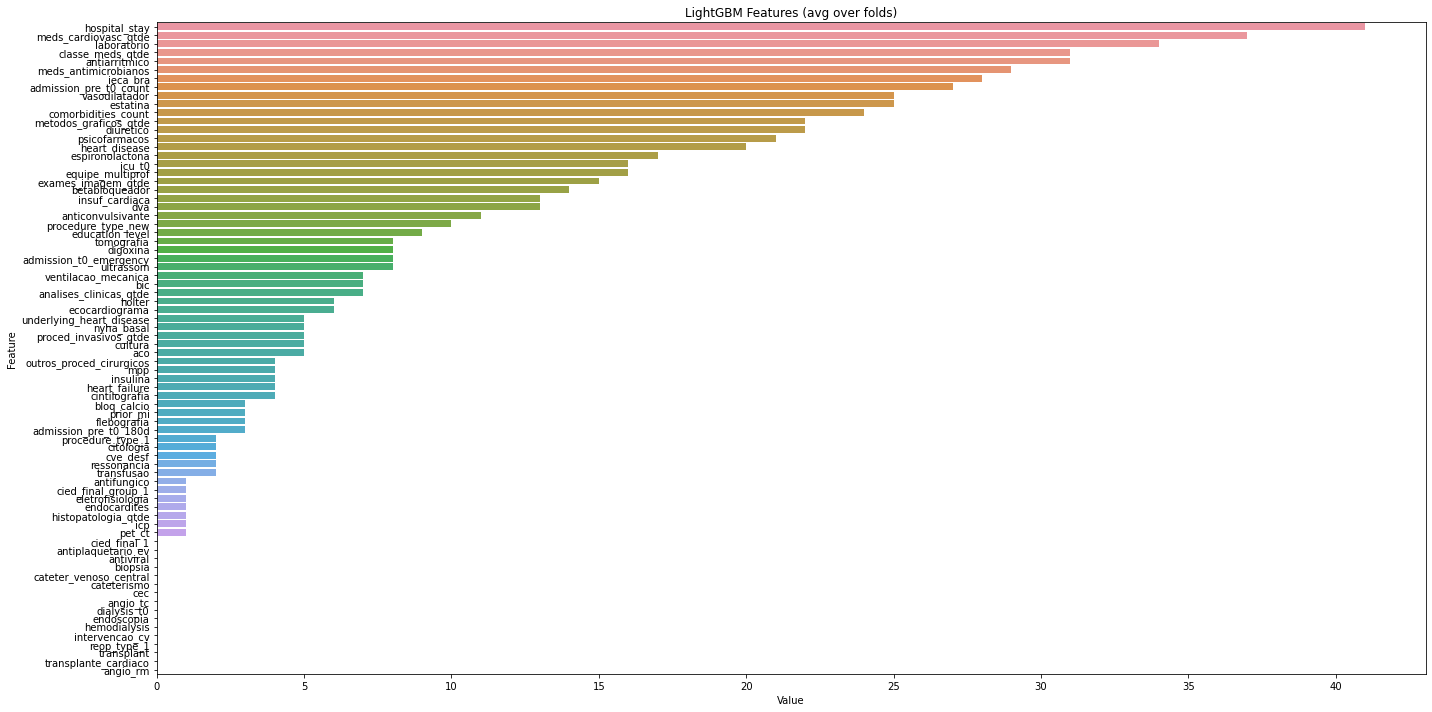

In [13]:
initial_model, _, feature_imp = fit_lightgbm(initial_features, plot_importance = True)

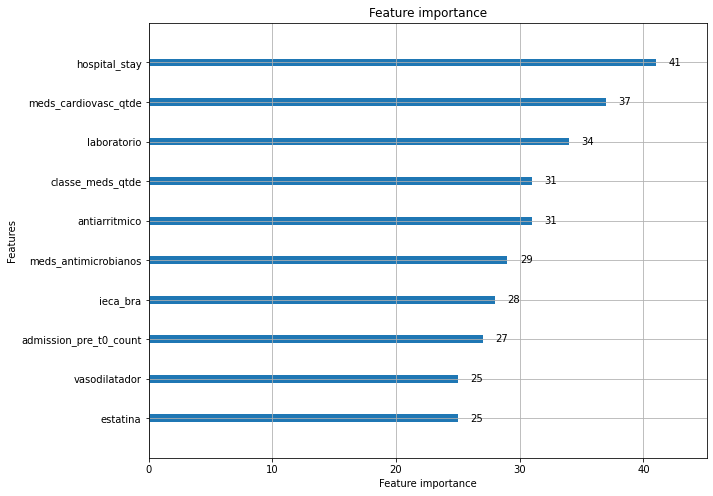

In [14]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 8)
lgb.plot_importance(initial_model, max_num_features = 10)
plt.show()

# Feature Selection

In [15]:
unimportant_features = feature_imp[feature_imp['Value'] == 0]['Feature'].tolist()

trimmed_features = list(set(initial_features) - set(unimportant_features))

print("Features with 0 importance: {}".format(len(unimportant_features)))
print("Trimmed number of features {}".format(len(trimmed_features)))

Features with 0 importance: 16
Trimmed number of features 60


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, th

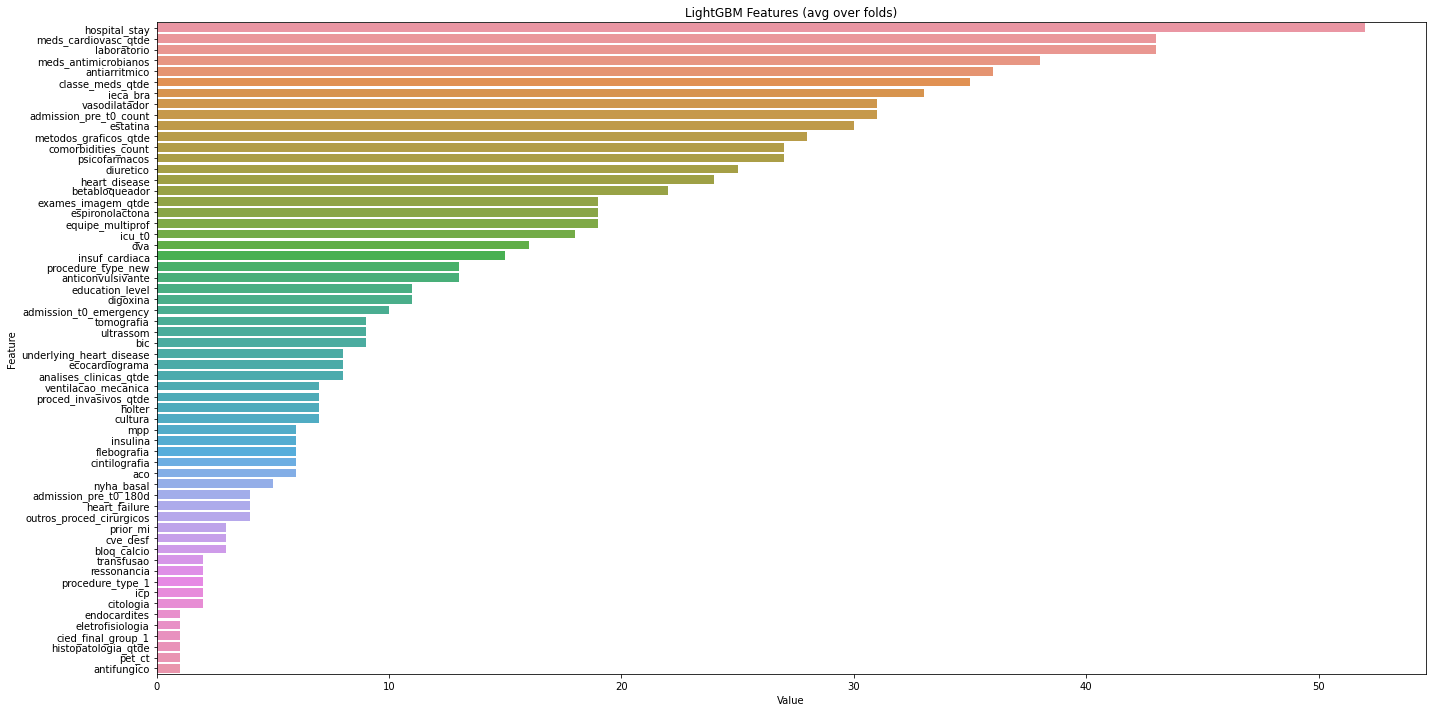

In [16]:
trimmed_model, trimmed_cv_results, _ = fit_lightgbm(trimmed_features, plot_importance = True)
n_estimators = len(trimmed_cv_results['auc-mean'])

# Hyperparameter Tuning

In [17]:
# Hyperparameter grid
param_grid = {
    'num_leaves': list(range(5, 25)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.2), base = 10, num = 10)),
#     'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 10)),
    'is_unbalance': [True, False]
}

In [18]:
random_results = random_search(trimmed_features, param_grid, n_estimators)

  0%|          | 0/30 [00:00<?, ?it/s]

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, th

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, th

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, th

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60

In [19]:
df_search, tuned_hyperparameters = evaluate_search(random_results, name = 'random search')

The highest cross validation score from random search was 0.69052 found on iteration 23.

The best hyperparameters were:
{'colsample_bytree': 0.6888888888888889,
 'is_unbalance': True,
 'learning_rate': 0.058480354764257315,
 'n_estimators': 28,
 'num_leaves': 20,
 'reg_alpha': 0.6326530612244897,
 'reg_lambda': 0.8571428571428571,
 'subsample': 0.6666666666666666}


In [20]:
df_search

,num_leaves,learning_rate,reg_alpha,reg_lambda,colsample_bytree,subsample,is_unbalance,n_estimators,iteration,score
0,20,0.058480,0.632653,0.857143,0.688889,0.666667,True,28,23,0.690523
1,9,0.088108,0.244898,0.775510,0.822222,0.666667,True,28,2,0.684373
2,16,0.025763,0.979592,0.693878,0.644444,1.000000,True,28,22,0.681965
3,12,0.007533,0.653061,0.040816,0.644444,0.555556,False,28,7,0.681765
4,22,0.011350,0.469388,0.163265,0.600000,0.777778,False,28,4,0.681328
5,19,0.025763,0.816327,0.367347,0.822222,0.722222,True,28,21,0.681154
6,14,0.005000,0.387755,0.387755,0.777778,0.555556,True,28,11,0.681016
7,19,0.007533,0.448980,0.795918,0.866667,0.611111,False,28,20,0.680964
8,13,0.025763,0.714286,0.244898,0.688889,0.722222,False,28,15,0.679564
9,13,0.007533,0.224490,0.612245,0.600000,0.666667,False,28,8,0.679136


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001522 seconds.
You can set `force_col_wise=true` to remove the overhead.

Found `n_estimators` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 60
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3100
[LightGBM] [Info] Number of 

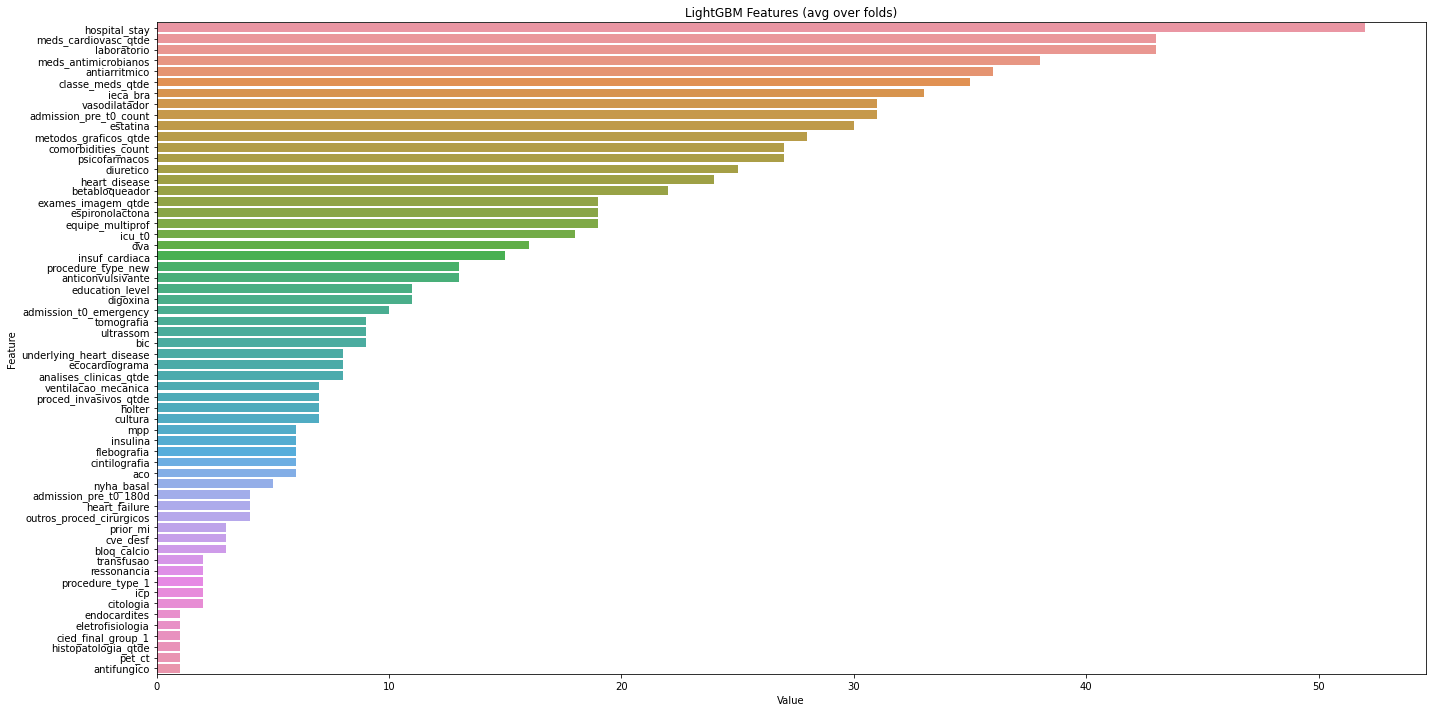

In [21]:
tuned_model, _, _ = fit_lightgbm(trimmed_features,
                                 hyperparameters=tuned_hyperparameters,
                                 early_stopping=False,
                                 plot_importance=True)